In [83]:
import os, random, json

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import scipy

from glob import glob

In [86]:
BASE_PATH     = '../data/raw/training_data/'
BASE_PATH_NORMALIZED = '../data/processed/normalized-images'

SAMPLE_NUMBER = '004'
SAMPLE_IMG    = os.path.join(BASE_PATH, f'verse{SAMPLE_NUMBER}.nii.gz')
SAMPLE_CTD    = os.path.join(BASE_PATH, f'verse{SAMPLE_NUMBER}_ctd.json')
SAMPLE_SNAP   = os.path.join(BASE_PATH, f'verse{SAMPLE_NUMBER}_snapshot.png')

SAMPLE_NORMALIZED_IMG = os.path.join(BASE_PATH_NORMALIZED, f'images/verse{SAMPLE_NUMBER}.mha')
SAMPLE_NORAMLIZED_CTD = os.path.join(BASE_PATH_NORMALIZED, f'centroid_masks/verse{SAMPLE_NUMBER}.mha')

In [87]:
files_to_delete = glob(os.path.join(BASE_PATH, 'verse*_seg.nii.gz'))

if len(files_to_delete) > 0:
    for file in files_to_delete: 
        os.remove(file)
    
IMAGES = glob(os.path.join(BASE_PATH_NORMALIZED, 'images/verse*.mha'))
IMAGES_CTD = [path.replace('images/', 'centroid_masks/') for path in IMAGES]

shapes = []
for image in IMAGES: 
    shapes.append(sitk.ReadImage(image).GetSize())


In [88]:
x, y, z = zip(*shapes)

print(f'Min value of X-axis: {min(x)}, max value is: {max(x)}')
print(f'Min value of Y-axis: {min(y)}, max value is: {max(y)}')
print(f'Min value of Z-axis: {min(z)}, max value is: {max(z)}')

Min value of X-axis: 38, max value is: 512
Min value of Y-axis: 103, max value is: 915
Min value of Z-axis: 149, max value is: 1189


In [89]:
def get_centroids_of_image(image_path):
    """
    Gets the centroid locations of vertebrae from a centroids mask 

    Args:
        image_path (str): Path to the centroids mask.

    Returns: 
        A dictionary containing labels as keys and a dictionary of coordinates as values in the following format:

        {
            1: {
                'x': 0, 
                'y': 0, 
                'z': 0,
            },
        }
    """

    img_centroids_mask = sitk.ReadImage(image_path)
    np_centroids_mask = sitk.GetArrayFromImage(img_centroids_mask)

    # Value of voxels correspond to label numbers, therefore we retrieve all unique values in the mask
    labels = np.unique(np_centroids_mask) 

    # We have to delete 0 values since these are padding and not centroid locations
    labels_without_zeros = np.delete(labels, 0) 

    centroids = {}

    for label in labels_without_zeros: 
        z, y, x = np.where(np_centroids_mask == label) # Axis are reversed when converting from sitk image to numpy array, therefore z, y, x
        centroids[label] = {'x': x.item(), 'y': y.item(), 'z': z.item()}

    return centroids


def generate_heatmap_target(heatmap_size, centroids, sigma=3.0):
    """
    Generates a heatmap images in the corresponding dimensions with regard to centroids using a Gaussian kernel.

    Args: 
        heatmap_size (tuple): The size of the image.
        centroids (dict): Dict containing all the centroid locations [x, y, z] in the corresponding heatmap.
        sigma (float): Sigma value used in by the Gaussian Kernel.

    Returns: 
        A numpy.ndarray containing heatmaps of centroids with same dimension as heatmap_size.
    """

    heatmap = np.zeros(heatmap_size)

    # Read all coordinates and change value in the heatmap to 1 in those locations
    for label, coordinates in centroids.items(): 
        x, y, z = coordinates['x'], coordinates['y'], coordinates['z']
        heatmap[x, y, z] = 1

    # Create Gaussian kernel
    x = np.arange(sigma * -2.5, sigma * 3)
    y = np.arange(sigma * -2.5, sigma * 3)
    z = np.arange(sigma * -2.5, sigma * 3)

    X, Y, Z = np.meshgrid(x, y, z)

    gaussian_kernel = np.exp(-(X**2 + Y**2 + Z**2)/(2*sigma**2))

    # Convolve the Gaussian Kernel on the heatmap where 1 corresponds to centroid location, generating heatmaps
    heatmap = scipy.signal.convolve(heatmap, gaussian_kernel, mode="same")

    return heatmap

def reshape(image, new_shape):
    """
    Reshapes an image to desired new shape. 

    Args: 
        image (numpy.ndarray): Image array .
        new_shape (tuple): Shape to which the image array should be reshaped.

    Returns: 
        A reshaped numpy.ndarray of the original image.
    """

    assert(image.ndim == len(new_shape))

    x = np.random.randint(0, image.shape[0] - new_shape[0])
    y = np.random.randint(0, image.shape[1] - new_shape[1])
    z = np.random.randint(0, image.shape[2] - new_shape[2])

    reshaped_image = image[x:x+new_shape[0], y:y+new_shape[1], z:z+new_shape[2]]
    
    return reshaped_image 

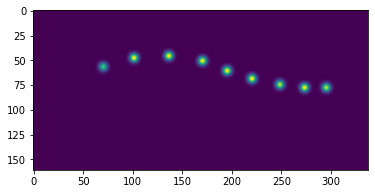

In [90]:
heatmap_size = sitk.ReadImage(SAMPLE_NORMALIZED_IMG).GetSize()
centroid_locations = get_centroids_of_image(SAMPLE_NORAMLIZED_CTD)

heatmap = generate_heatmap_target(heatmap_size, centroid_locations)
plt.imshow(heatmap[29])

In [91]:
img = sitk.ReadImage(SAMPLE_NORMALIZED_IMG)
np_img = sitk.GetArrayFromImage(img)

new_shape = (32, 64, 60)

img_reshaped = reshape(np_img, new_shape)

heatmap_size = sitk.ReadImage(SAMPLE_NORMALIZED_IMG).GetSize()
centroid_locations = get_centroids_of_image(SAMPLE_NORAMLIZED_CTD)

heatmap = generate_heatmap_target(heatmap_size, centroid_locations)

heatmap_reshaped = reshape(heatmap, new_shape)

print(img_reshaped.shape)
print(heatmap_reshaped.shape)

plt.imshow(heatmap[29]

SyntaxError: unexpected EOF while parsing (<ipython-input-91-a69c8f4ef511>, line 18)

In [ ]:
# create 3d u-net
# input = image
# output = x*y grid, each containing:
# one centroid location with x,y,w,h and the class (1-25) with a certainty score of: c

def U_net_3D_model():
    inputs = tf.keras.Input(shape=(None,32,64,64))
    
    #block 1
    x = tf.keras.layers.Conv3D(32, (3,3,3) , padding="same") (inputs)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(64, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    s1 = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(s1)
    
    #block 2
    x = tf.keras.layers.Conv3D(64, (3,3,3) , padding="same") (inputs)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(128, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    s2 = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(s2)
    
    #block 3
    x = tf.keras.layers.Conv3D(128, (3,3,3) , padding="same") (inputs)
    x = tf.keras.layers.BatchNormalization() (x)
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(256, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    s3 = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(s3)
    
    #bottom
    x = tf.keras.layers.Conv3D(256, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(512, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    # block 4
    x = tf.keras.layers.UpSampling3D(size = (2,2,2)) (x)
    x = concatenate([s3,x], axis = 4)
    
    x = tf.keras.layers.Conv3D(256, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(256, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    # block 5
    x = tf.keras.layers.UpSampling3D(size = (2,2,2)) (x)
    x = concatenate([s2,x], axis = 4)
    
    x = tf.keras.layers.Conv3D(128, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(128, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    # block 6
    x = tf.keras.layers.UpSampling3D(size = (2,2,2)) (x)
    x = concatenate([s2,x], axis = 4)
    
    x = tf.keras.layers.Conv3D(64, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    x = tf.keras.layers.Conv3D(64, (3,3,3) , padding="same") (x)
    x = tf.keras.layers.BatchNormalization()
    x = tf.keras.activations.relu(alpha=0.0, max_value=None, threshold=0) (x)
    
    # output layer
    outputs = tf.keras.layers.Conv3D(25, (1,1,1) , padding="same") (x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# loss function
# must generate centroids from 25 output channels
# parameters;
# y_true: 2d-array, list of [x,y,z,label]

# TODO CHANGE TO CALCULATE L2 LOSS BASED ON HEATMAPS
def loss(y_true, y_pred):
    threshold = 1
    y_true_x_y_z_labels = []
    for i in range(len(y_pred)):
        if(np.max(y_pred[i]) > threshold):
            newlabel = np.concat(np.argmax(y_pred[i]), [i+1])
            y_true_x_y_z_labels.append(newlabel)
    
    # case 1:
    # if label is in y_true and not in y_pred:
    # check activation strength of location y_true
    
    # case 2:
    # if label is not in y_true and in y_pred:
    # add total output of channel to loss
    
    # case 3:
    # if label is in y_true and y_pred:
    # - check activation strength of location y_true
    # - (or) check distance between y_true and y_pred
    # - 